In [17]:
import tensorflow as tf

from tensorflow.keras import layers, models, callbacks, saving
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
def run_train(split_number: int, epochs=100):
    NUM_CLASSES = 5

    model = models.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(64, 64, 3)))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((4, 4)))
    model.add(layers.Conv2D(256, (4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES))
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()

    train_ds = tf.keras.utils.image_dataset_from_directory(
      f"SPLIT_{split_number}/training",
      batch_size=16,
      image_size=(64, 64),
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
      f"SPLIT_{split_number}/validation",
      batch_size=16,
      image_size=(64, 64),
    )
    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    checkpoint = callbacks.ModelCheckpoint(
        filepath=f'MODEL{split_number}.keras', 
        verbose=1, 
        monitor='val_accuracy',
        save_best_only=True, 
        mode='max'
    )

    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      callbacks=[checkpoint]
    )

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(6, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.savefig(f'Accuracy_{split_number}.png')
    plt.show()
    
    plt.figure(figsize=(6, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(f'Loss_{split_number}.png')
    plt.show()

    return model, history

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,120,389 (4.27 MB)

 Trainable params: 1,120,389 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 16181 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Epoch 1/50
1001/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5038 - loss: 1.2225
Epoch 1: val_accuracy improved from -inf to 0.73200, saving model to MODEL1.keras
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5049 - loss: 1.2203 - val_accuracy: 0.7320 - val_loss: 0.8304
Epoch 2/50
 999/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7268 - loss: 0.7443
Epoch 2: val_accuracy improved from 0.73200 to 0.78000, saving model to MODEL1.keras
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7270 - loss: 0.7438 - val_accuracy: 0.7800 - val_loss: 0.6776
Epoch 3/50
1001/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7864 - loss: 0.5919
Epoch 3: val_accuracy did not improve from 0.78000
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7865 - loss: 0.5917 - val_accuracy: 0.7800 - val_loss: 0.5763
Epoch 4/50
1005/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8249 - loss

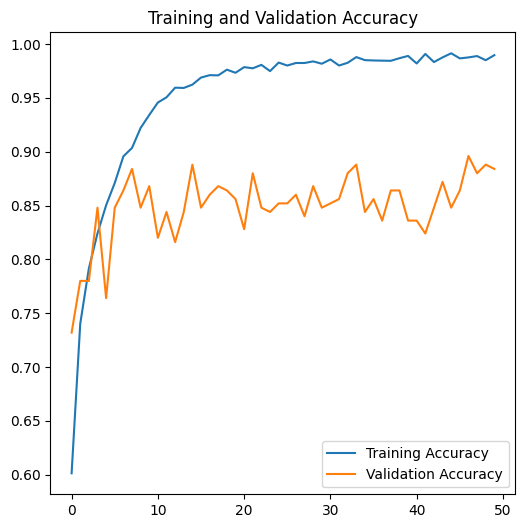

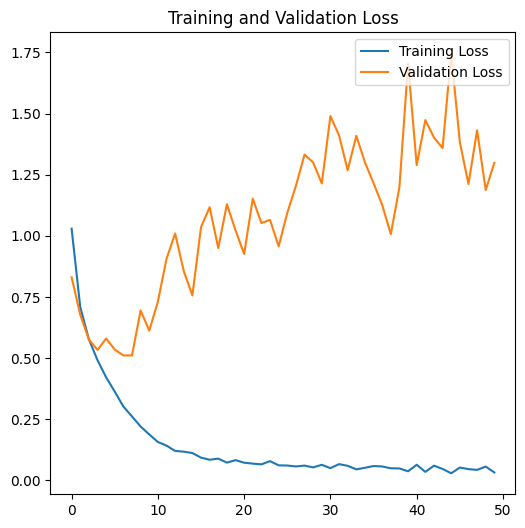

In [14]:
model1, history1 = run_train(1, epochs=50)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,120,389 (4.27 MB)

 Trainable params: 1,120,389 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 49999 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Epoch 1/50
3115/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5012 - loss: 1.1847
Epoch 1: val_accuracy improved from -inf to 0.80400, saving model to MODEL2.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5016 - loss: 1.1840 - val_accuracy: 0.8040 - val_loss: 0.6451
Epoch 2/50
3122/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7412 - loss: 0.7004
Epoch 2: val_accuracy improved from 0.80400 to 0.84400, saving model to MODEL2.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7412 - loss: 0.7004 - val_accuracy: 0.8440 - val_loss: 0.5423
Epoch 3/50
3117/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7840 - loss: 0.5818
Epoch 3: val_accuracy did not improve from 0.84400
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7840 - loss: 0.5817 - val_accuracy: 0.8200 - val_loss: 0.4823
Epoch 4/50
3119/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - l

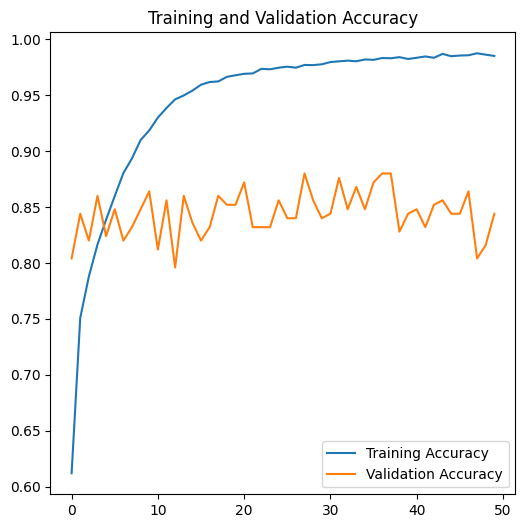

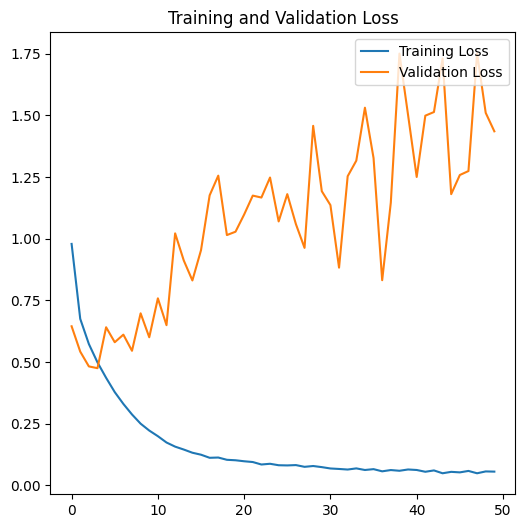

In [15]:
model2, history2 = run_train(2, epochs=50)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,120,389 (4.27 MB)

 Trainable params: 1,120,389 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 50249 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Epoch 1/50
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4409 - loss: 1.2785
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to MODEL3.keras
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.4409 - loss: 1.2784 - val_accuracy: 0.7600 - val_loss: 0.6319
Epoch 2/50
3133/3141 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7059 - loss: 0.7717
Epoch 2: val_accuracy improved from 0.76000 to 0.86000, saving model to MODEL3.keras
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7059 - loss: 0.7716 - val_accuracy: 0.8600 - val_loss: 0.4532
Epoch 3/50
3133/3141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7657 - loss: 0.6325
Epoch 3: val_accuracy did not improve from 0.86000
3141/3141 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7657 - loss: 0.6325 - val_accuracy: 0.8560 - val_loss: 0.3926
Epoch 4/50
3140/3141 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7974 - l

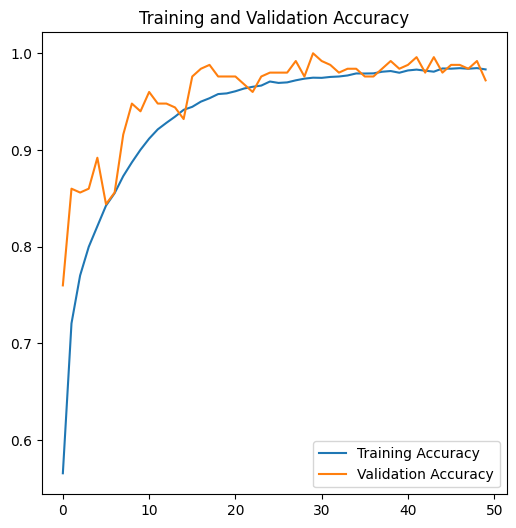

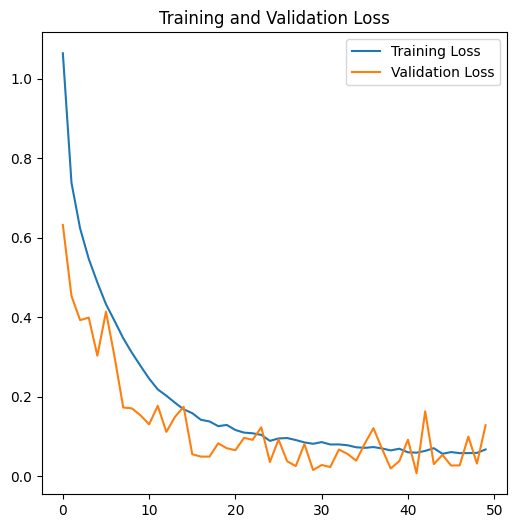

In [16]:
model3, history3 = run_train(3, epochs=50)

In [75]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    f"SPLIT_1/testing",
    image_size=(64, 64),
    batch_size=32
)

Found 250 files belonging to 5 classes.


In [79]:
model1 = saving.load_model("MODEL1.keras")

accuracy = model1.evaluate(test_ds, verbose=0)[1]
print(round(accuracy, 3))

0.856


In [80]:
model2 = saving.load_model("MODEL2.keras")

accuracy = model2.evaluate(test_ds, verbose=0)[1]
print(round(accuracy, 3))

0.844


In [81]:
model3 = saving.load_model("MODEL3.keras")

accuracy = model3.evaluate(test_ds, verbose=0)[1]
print(round(accuracy, 3))

0.848
